# Survival model development

In [2]:
import torch
import torch.nn as nn
import math
import ukko 
import importlib
# For preprocessing
print("Loading sklearn")
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import pandas as pd
import numpy as np
print("Libraries loaded")

Loading sklearn
Libraries loaded


In [3]:
class SurvivalHead(nn.Module):
    """
    Neural Cox proportional hazards model head.
    Outputs hazard ratios instead of binary classification.
    """
    def __init__(self, d_model, n_features, dropout=0.1):
        super().__init__()
        self.risk_score = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)  # log hazard ratio
        )

    def forward(self, x):
        # Risk score (log hazard ratio)
        return torch.exp(self.risk_score(x))  # hazard ratio

    
def cox_loss(risk_scores, survival_times, events):
    """
    Negative log partial likelihood for Cox model
    
    Args:
        risk_scores: predicted hazard ratios
        survival_times: time to event/censoring
        events: 1 if event occurred, 0 if censored
    """
    # Sort by survival time
    _, indices = torch.sort(survival_times, descending=True)
    risk_scores = risk_scores[indices]
    events = events[indices]
    
    # Calculate log partial likelihood
    log_risk = torch.log(torch.cumsum(torch.exp(risk_scores), 0))
    likelihood = risk_scores - log_risk
    
    # Mask for events only
    return -torch.mean(likelihood * events)

In [4]:
class SurvivalDataset(Dataset):
    def __init__(self, features, survival_times, events):
        self.features = features
        self.times = survival_times    # Time to event/censoring
        self.events = events           # Event indicator (1=death, 0=censored)

NameError: name 'Dataset' is not defined

In [5]:
#Load tidy data
print("Loading tidy data")
df_xy = pd.read_csv("data/df_xy_synth_v1.csv")
# IMPUTE nan: -1
df_xy = df_xy.fillna(-1)

# Define function to convert df into 3-D numpy array
def convert_to_3d_df(df):

    # Convert column names to tuples, assuming this "('feature', timepoint)"
    columns = [eval(col) for col in df.columns]
    df.columns = columns
    
    # Extract unique features and timepoints
    features = sorted(list(set([col[0] for col in columns])))
    timepoints = sorted(list(set([col[1] for col in columns])))
    
    # Initialize a 3D numpy array
    n_rows = df.shape[0]
    n_features = len(features)
    n_timepoints = len(timepoints)
    data_3d = np.empty((n_rows, n_features, n_timepoints))
    data_3d.fill(np.nan)
    
    # Map feature names and timepoints to indices
    feature_indices = {feature: i for i, feature in enumerate(features)}
    timepoint_indices = {timepoint: i for i, timepoint in enumerate(timepoints)}
    
    # Fill the 3D array with data from the DataFrame
    for col in columns:
        feature, timepoint = col
        feature_idx = feature_indices[feature]
        timepoint_idx = timepoint_indices[timepoint]
        data_3d[:, feature_idx, timepoint_idx] = df[col]

    # Create a MultiIndex for the columns of the 3D DataFrame
    columns = pd.MultiIndex.from_product([features, timepoints], names=["Feature", "Timepoint"])
    
    # Create the 3D DataFrame
    df_multiindex = pd.DataFrame(data_3d.reshape(n_rows, -1), columns=columns)
    
    return df_multiindex, data_3d

# Convert AML data to multiindex df
df_x, data_3d = convert_to_3d_df(df_xy.iloc[:,3:].fillna(-1))
df_y = df_xy.iloc[:,:3]
display(df_x)
display(df_y)


Loading tidy data


Feature   Basophils/100 leukocytes in Blood                                    \
Timepoint                             -5.0  -4.0  -3.0  -2.0  -1.0       0.0    
0                                      -1.0  -1.0  -1.0  -1.0  -1.0  0.850735   
1                                       2.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
2                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
3                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
4                                      -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
..                                      ...   ...   ...   ...   ...       ...   
995                                    -1.0  -1.0  -1.0  -1.0  -1.0  0.365545   
996                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
997                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   
998                                    -1.0  -1.0  -1.0  -1.0  -1.0  0.714543   
999                                    -1.0  -1.0  -1.0  -1.0  -1.0 -1.000000   

Feature                            ... Platelets [#/volume] in Blood  \
Timepoint  1.0   2.0   3.0   4.0   ...                          12.0   
0          -1.0  -1.0  -1.0  -1.0  ...                     35.267531   
1          -1.0   0.8   0.6  -1.0  ...                     17.644103   
2           0.9   0.2  -1.0  -1.0  ...                     33.075386   
3          -1.0  -1.0  -1.0  -1.0  ...                     19.108278   
4          -1.0  -1.0  -1.0  -1.0  ...                     27.111444   
..          ...   ...   ...   ...  ...                           ...   
995        -1.0  -1.0  -1.0  -1.0  ...                     32.470881   
996        -1.0  -1.0  -1.0  -1.0  ...                     74.535567   
997        -1.0  -1.0   0.0  -1.0  ...                     10.970071   
998        -1.0  -1.0  -1.0  -1.0  ...                     30.374466   
999        -1.0  -1.0  -1.0  -1.0  ...                     47.135066   

Feature                                                                      \
Timepoint       13.0       14.0       15.0       16.0       17.0       18.0   
0          21.842999  26.972079   6.470798  25.946376  35.851646  -1.000000   
1           5.856022  33.222468  30.042670  10.961655  16.626338  14.611647   
2          19.972356  -1.000000  10.159840   7.403816  32.169956  13.245301   
3          -1.000000  10.593051  -1.000000   2.842802  11.054564  -1.000000   
4           8.762440  22.310250  25.011994  18.616336   8.396031  11.796703   
..               ...        ...        ...        ...        ...        ...   
995        39.852095  45.119058  -1.000000  19.426973  -1.000000  15.334406   
996        32.166004  -1.000000  37.804129  -1.000000  40.128945  18.025300   
997        -1.000000  -1.000000   5.812085  51.490996  37.736588  20.504332   
998        -1.000000  10.356835  -1.000000   9.787053  -1.000000  50.671958   
999        50.443120   7.596205  58.148557  26.659284  -1.000000  24.875252   

Feature                                     
Timepoint       19.0       20.0       21.0  
0          -1.000000  -1.000000  -1.000000  
1           6.030153  27.483864  -1.000000  
2          18.461631  -1.000000   4.782206  
3          23.594939  27.795295  -1.000000  
4           1.913356   0.251289  -1.000000  
..               ...        ...        ...  
995        43.252142  30.149195  -1.000000  
996        -1.000000  50.305928  51.343236  
997        31.987580  22.532788  -1.000000  
998        45.541768  -1.000000  -1.000000  
999        35.821172  -1.000000  -1.000000  

[1000 rows x 270 columns]

,person_id,OSS_days,OSS_status
0,0,1101.0,1
1,1,532.0,1
2,2,985.0,0
3,3,90.0,1
4,4,1885.0,0
...,...,...,...
995,995,1835.0,0
996,996,941.0,0
997,997,2.0,1
998,998,77.0,0


## Custom Cox PH implementation

In [14]:
class LinearCoxPH(nn.Module):
    """
    Classical Cox PH with linear predictor: h(t|x) = h₀(t)exp(βx)
    """
    def __init__(self, n_features):
        super().__init__()
        self.beta = nn.Linear(n_features, 1, bias=False)  # β coefficients
        
    def forward(self, x):
        return torch.exp(self.beta(x))  # exp(βx)

In [6]:
class CoxPHModel(nn.Module):
    """
    Classical Cox Proportional Hazards model implemented in PyTorch.
    Learns a linear combination of features to predict hazard ratios.
    """
    def __init__(self, n_features, hidden_size=32):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Linear hazard prediction
        self.hazard_ratio = nn.Sequential(
            nn.Linear(n_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        """
        Compute hazard ratios for each sample.
        
        Args:
            x: Input features [batch_size, n_features]
            
        Returns:
            hazard_ratios: Predicted hazard ratios [batch_size, 1]
        """
        return torch.exp(self.hazard_ratio(x))  # exp(β * x)

In [7]:
def cox_loss(hazard_ratios, durations, events):
    """
    Negative log partial likelihood for Cox model.
    
    Args:
        hazard_ratios: Predicted hazard ratios [batch_size, 1]
        durations: Time to event/censoring [batch_size]
        events: Event indicators (1=event, 0=censored) [batch_size]
    
    Returns:
        loss: Negative log partial likelihood
    """
    # Sort all arrays by duration in descending order
    sorted_idx = torch.argsort(durations, descending=True)
    hazard_ratios = hazard_ratios[sorted_idx]
    events = events[sorted_idx]
    
    # Calculate log risk (cumulative hazard)
    log_risk = torch.logcumsumexp(hazard_ratios.flatten(), dim=0)
    
    # Select events that contribute to likelihood
    event_indices = (events == 1).nonzero().flatten()
    
    if len(event_indices) == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # Calculate negative log likelihood
    partial_likelihood = hazard_ratios[event_indices].flatten() - log_risk[event_indices]
    neg_likelihood = -torch.mean(partial_likelihood)
    
    return neg_likelihood

In [8]:
def train_cox_model(model, train_loader, val_loader, epochs=100, lr=0.001, device='cpu'):
    """
    Train Cox proportional hazards model.
    
    Args:
        model: CoxPHModel instance
        train_loader: DataLoader with (features, durations, events)
        val_loader: DataLoader with (features, durations, events)
        epochs: Number of training epochs
        lr: Learning rate
        device: 'cuda' or 'cpu'
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, durations, events in train_loader:
            x = x.float().to(device)
            durations = durations.float().to(device)
            events = events.float().to(device)
            
            optimizer.zero_grad()
            hazard_ratios = model(x)
            loss = cox_loss(hazard_ratios, durations, events)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, durations, events in val_loader:
                x = x.float().to(device)
                durations = durations.float().to(device)
                events = events.float().to(device)
                
                hazard_ratios = model(x)
                val_loss += cox_loss(hazard_ratios, durations, events).item()
        
        # Log metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_cox_model.pt')
            
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    return history

In [10]:
from torch.utils.data import Dataset

class SurvivalDataset(Dataset):
    """
    Dataset for survival analysis with Cox PH model.
    """
    def __init__(self, features, durations, events):
        self.features = torch.FloatTensor(features)
        self.durations = torch.FloatTensor(durations)
        self.events = torch.FloatTensor(events)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return (self.features[idx], 
                self.durations[idx], 
                self.events[idx])


In [ ]:
# Test/Example data

# from sksurv.datasets import load_veterans_lung_cancer

# data_x, data_y = load_veterans_lung_cancer()
# data_y

from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset() # a Pandas DataFrame
regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1


In [ ]:
display(regression_dataset)

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1
...,...,...,...,...,...
195,0.137399,0.107748,0.354812,11.445457,1
196,0.637341,2.847188,1.459137,7.624627,1
197,1.109732,0.405561,0.018856,10.634620,1
198,0.031865,1.753759,0.252040,8.519718,1


In [16]:
# Example usage
from torch.utils.data import DataLoader

# Split data
df_train = regression_dataset.sample(frac=0.8)
df_val = regression_dataset.drop(df_train.index)

# Create datasets
train_dataset = SurvivalDataset(
    features=df_train.drop(columns=['T', 'E']).values,
    durations=df_train['T'].values,
    events=df_train['E'].values
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True
)

val_dataset = SurvivalDataset(
    features=df_val.drop(columns=['T', 'E']).values,
    durations=df_val['T'].values,
    events=df_val['E'].values
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False
)

# # Define model
# n_features = 3
# model = CoxPHModel(n_features=n_features)

# # Train model
# history = train_cox_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=100
# )

model2 = LinearCoxPH(n_features=n_features)

# Train model
history = train_cox_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100
)


Epoch 0: train_loss=2.7957, val_loss=2.3117
Epoch 10: train_loss=2.7072, val_loss=2.2493
Epoch 20: train_loss=2.6648, val_loss=2.2072
Epoch 30: train_loss=2.6473, val_loss=2.1767
Epoch 40: train_loss=2.6514, val_loss=2.1528
Epoch 50: train_loss=2.5853, val_loss=2.1350
Epoch 60: train_loss=2.6226, val_loss=2.1204
Epoch 70: train_loss=2.6072, val_loss=2.1086
Epoch 80: train_loss=2.5919, val_loss=2.0986
Epoch 90: train_loss=2.5777, val_loss=2.0899


In [22]:
def get_risk_groups(model, data_loader, device='cpu'):
    """Get risk scores for all patients and split into high/low risk groups"""
    model.eval()
    all_risks = []
    all_times = []
    all_events = []
    
    with torch.no_grad():
        for x, durations, events in data_loader:
            x = x.float().to(device)
            hazard_ratios = model(x)
            # Ensure 1D arrays
            all_risks.append(hazard_ratios.cpu().numpy().flatten())
            all_times.append(durations.numpy().flatten())
            all_events.append(events.numpy().flatten())
    
    # Concatenate all predictions
    risk_scores = np.concatenate(all_risks)
    times = np.concatenate(all_times)
    events = np.concatenate(all_events)
    
    # Split into high/low risk groups using median
    median_risk = np.median(risk_scores)
    high_risk = risk_scores >= median_risk
    
    return risk_scores, times, events, high_risk

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def plot_risk_stratification(times, events, high_risk, title="Risk Stratification"):
    """Plot Kaplan-Meier curves for high and low risk groups"""
    
    # Initialize KM estimator
    kmf = KaplanMeierFitter()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot high risk group
    mask = high_risk.astype(bool)  # Ensure boolean mask
    kmf.fit(times[mask], events[mask], label='High Risk')
    kmf.plot()
    
    # Plot low risk group
    mask = ~high_risk.astype(bool)  # Ensure boolean mask
    kmf.fit(times[mask], events[mask], label='Low Risk')
    kmf.plot()
    
    # Customize plot
    plt.title(title)
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    
    # Add log-rank test
    from lifelines.statistics import logrank_test
    log_rank = logrank_test(times[high_risk], times[~high_risk],
                           events[high_risk], events[~high_risk])
    plt.text(0.05, 0.05, f'Log-rank p-value: {log_rank.p_value:.3e}',
             transform=plt.gca().transAxes)
    
    return plt.gcf()

Concordance Index: 0.520


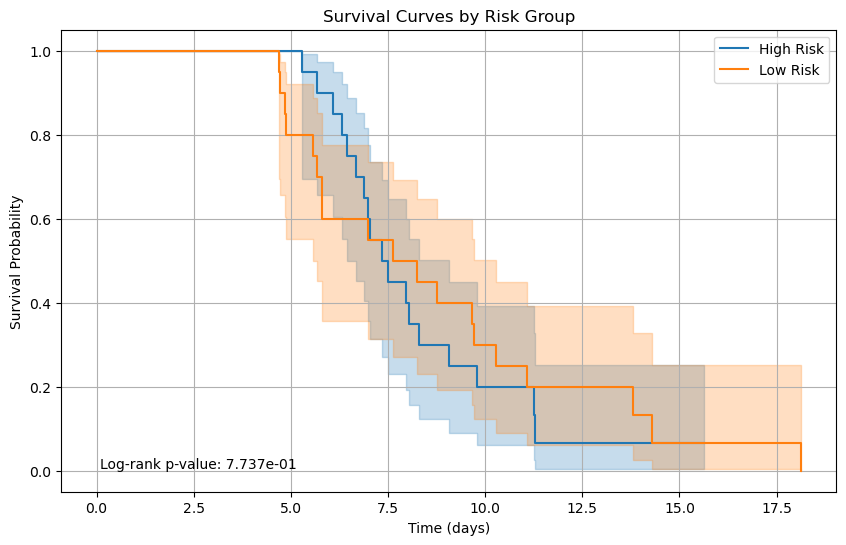

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load best model
#best_model = CoxPHModel(n_features=n_features)
best_model = LinearCoxPH(n_features=n_features)
best_model.load_state_dict(torch.load('best_cox_model.pt'))
best_model = best_model.to(device)

# Get risk groups
risk_scores, times, events, high_risk = get_risk_groups(best_model, val_loader, device)

# Plot Kaplan-Meier curves
fig = plot_risk_stratification(times, events, high_risk, 
                             title="Survival Curves by Risk Group")

# Add additional metrics
from lifelines.utils import concordance_index
c_index = concordance_index(times, -risk_scores.flatten(), events)
print(f"Concordance Index: {c_index:.3f}")

## Comparision Cox PH from lifelines

In [26]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(regression_dataset, duration_col='T', event_col='E')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 200 total observations, 11 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 189
   partial log-likelihood = -807.62
         time fit was run = 2025-03-14 17:31:29 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
var1       0.22      1.25      0.07            0.08            0.37                1.08                1.44
var2       0.05      1.05      0.08           -0.11            0.21                0.89                1.24
var3       0.22      1.24      0.08            0.07            0.37                1.07                1.44

           cmp to    z      p  -log2(p)
covariate                              
var1         0.00 2.99 <0.005      8.49
var2         0.00 0.61   0.54      0.89
var3         0.00 2.88 <0.005      7.97
---
Concordance = 0.58
Partial AIC = 1621.24
log-likelihood ratio test = 15.54 on 3 df
-log2(p) of ll-ratio test = 9.47

In [32]:
print(regression_dataset.shape)
risk = cph.predict_partial_hazard(regression_dataset)
print (risk)
print (np.median(risk))
high_risk = risk >= np.median(risk)

(200, 5)
0      1.088230
1      0.729708
2      0.844264
3      0.819460
4      1.398511
         ...   
195    0.714989
196    1.169180
197    0.837295
198    0.742672
199    2.235417
Length: 200, dtype: float64
0.9390955578286115


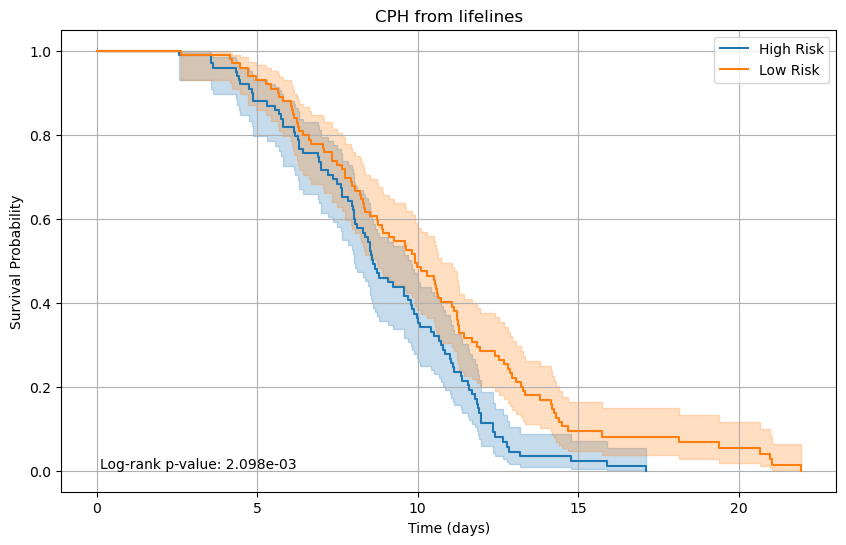

In [33]:
df = regression_dataset.copy()
fig = plot_risk_stratification(df['T'], df['E'], high_risk, 
                             title="CPH from lifelines")